- This Notebook contains Experiements with **Amazon Beauty** Dataset for the following models:

- **Updated PSI**

- **Regular PSI**

- **Pure SVD**

- **Most Pop**

- **Rand Rec**

## Imports

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "8"        #export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "8"   #export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "8"        #export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "8"

In [ ]:
import io
import os
import gzip
import json
import scipy
import random
import warnings
import numpy as np
import numba as nb
import pandas as pd
import datetime as dt
import seaborn as sns
from tqdm import tqdm
import scipy.stats as st
from collections import OrderedDict
import scipy.sparse as sparse
from scipy.linalg import orth
import matplotlib.pyplot as plt
from numpy import linalg as lin
warnings.filterwarnings('ignore')
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds
from datetime import datetime as dt_dt
from scipy.sparse.linalg import spsolve
from numpy.linalg import qr as QR_decomp
from scipy.sparse import csr_matrix, find
from pandas.api.types import CategoricalDtype
from typing import List
import torch
import torch.nn.functional as F
from torch import nn
from polara.evaluation.pipelines import random_grid
import bottleneck as bn
import pickle

In [ ]:
from  polara import RecommenderData
import os; os.environ["MKL_NUM_THREADS"] = "1" # as required by implicit
import numpy as np

from polara.recommender.external.implicit.ialswrapper import ImplicitALS
from polara.evaluation.pipelines import random_grid, set_config,find_optimal_config

## Functions

In [ ]:
import sys
sys.path.append('/home/oolaleke/incremental_PSI/Scripts/')

In [ ]:
import a_DataHelpers
import b_AlgoFunctions
import c_PredEval
import d_CorrScores
import e_VAEfunction

In [ ]:
# import sys
# sys.path.append('/content/drive/MyDrive/ColabNotebooks/Research/Functions/')

In [ ]:
from a_DataHelpers import getPivotMonths,Time_DataSplit,TestTrain_DataSplit,SingleRatingMatrix
from a_DataHelpers import AllRatingMatrices,All_SingleStepRatMat,psiStep_RatMat,psiAllStep_RatMat
from a_DataHelpers import Find_NewUsersItems,adjustedPSI_DF,adjustedAllDF,get_NEWHoldout,ADJUST_mainDF
from a_DataHelpers import  SingleStepRatMat_2,AllSingleStepRatMat_2

from b_AlgoFunctions import integrator,getStartingValues,integratorOnMat,last_psiTrainMat, pureSVD
from b_AlgoFunctions import Updt_RowMatrix,getRow_Mat,row_update, Updt_ColMatrix,getCol_Mat,colunm_update
from b_AlgoFunctions import UsersItems_RatPair,getRowCol_psiupdt,ITEMS_defferredStatus,USERS_defferredStatus
from b_AlgoFunctions import getV_listUpdate, SingleStep_UPDATE,ALLSTEPs_UPDATE
from b_AlgoFunctions import tune_ALS,auc_score,TrainTest,mean_auc,getiALS_VUlist
from b_AlgoFunctions import HitrEval_noprint,SVDoptimalSearch

from c_PredEval import TopNPred,TQDMgetALLTopNPred, Hitrate_Eval,getAll_HitRate,mean_confidence_interval
from c_PredEval import TQDMgetALLTopNPred_ALLUSERS,getALLTopNPred_ALLUSERS,get_ALLRandPred
from c_PredEval import topN_Index,getAll_RandomHitRate,getMOSTPOP_Pred,getAll_MostPOPHitRate,getAll_MOSTPOP_Pred
from c_PredEval import StepCoverage_Ratio,AllSteps_Coverage_Ratio,getAll_VAEMRR
from c_PredEval import MRR_Eval,getAll_MRR_Eval,TQDMgetAll_MRR_Eval, getAll_MostPOP_MRR,getAll_RandomRecMRR
from c_PredEval import ials_TopNPred, ials_getALLPred, ials_getALLPredTQDM,ialsALLPred_ALLUSERS

from d_CorrScores import no_copy_csr_matrix,build_rank_weights_matrix,rank_weighted_jaccard_index
from d_CorrScores import Updt_getAll_AvgCorr, updtCorr_4AllRanks

from e_VAEfunction import split_users, split_train_test, numerize_data, get_TrainRatMat, getTrainTest_RatMat


In [ ]:

def get_NEWHoldout(HOLDOUT_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,user_col,item_col):
    newHOLDOUT_LIST =  []
    for DF,Updt_Users,Updt_Items in tqdm(zip(HOLDOUT_list,AllUpdtUSERS_,AllUpdtITEMS_)):
        df = DF.copy()
        newHOLDOUT_ =   df.loc[(df[item_col].isin(Updt_Items)) & (df[user_col].isin(Updt_Users))]#
        newHOLDOUT_ =   newHOLDOUT_[[user_col,item_col]]

        prevUser_ID =   newHOLDOUT_[user_col].values  ##
        prevItems_ID =  newHOLDOUT_[item_col].values   #
        Updted_UserID = [userID_dict.get(user) for user in prevUser_ID]   
        Updted_ItemID = [itemID_dict.get(item) for item in prevItems_ID]

        newHOLDOUT_['Updated_UserID'] = Updted_UserID
        newHOLDOUT_['Updated_ItemID'] = Updted_ItemID
        newHOLDOUT_LIST.append(newHOLDOUT_)
    return  newHOLDOUT_LIST


def adjustedAllDF(AllDF_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,user_col,item_col):
    newAllDF_list =[]
    for DF, Updt_Users, Updt_Items in tqdm(zip(AllDF_list,AllUpdtUSERS_,AllUpdtITEMS_)):
        df = DF.copy()
        df = df[[user_col,item_col]]
        allnew_df     = df.loc[(df[item_col].isin(Updt_Items)) & (df[user_col].isin(Updt_Users))]

        prevUser_ID =   allnew_df[user_col].values  
        prevItems_ID =  allnew_df[item_col].values   
        Updted_UserID = [userID_dict.get(user) for user in prevUser_ID]   
        Updted_ItemID = [itemID_dict.get(item) for item in prevItems_ID]
        allnew_df['Updated_UserID'] = Updted_UserID
        allnew_df['Updated_ItemID'] = Updted_ItemID
        newAllDF_list.append(allnew_df)
    return newAllDF_list

def adjustedPSI_DF(PSITest_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,user_col,item_col):
    new_PSIDFlist =[]
    for DF, Updt_Users, Updt_Items in tqdm(zip(PSITest_list,AllUpdtUSERS_,AllUpdtITEMS_)):
        df = DF.copy()
        df = df[[user_col,item_col]]
        new_PSIdf     = df.loc[(df[item_col].isin(Updt_Items)) & (df[user_col].isin(Updt_Users))]

        prevUser_ID =   new_PSIdf[user_col].values  
        prevItems_ID =  new_PSIdf[item_col].values   
        Updted_UserID = [userID_dict.get(user) for user in prevUser_ID]   
        Updted_ItemID = [itemID_dict.get(item) for item in prevItems_ID]
        new_PSIdf['Updated_UserID'] = Updted_UserID
        new_PSIdf['Updated_ItemID'] = Updted_ItemID
        new_PSIDFlist.append(new_PSIdf)
    return new_PSIDFlist




In [ ]:
#######################################################################
      ##get Rating Matrices based on single step interaction only 
def SingleStepRatMat_2(DF,user_column,item_column):  ##rows_ = n_users,cols_ = n_items
    rows_ = DF[user_column].max()+1 
    cols_ = DF[item_column].max()+1 
    
    rows0 = DF[user_column].values
    cols0 = DF[item_column].values
    data  = np.broadcast_to(1., DF.shape[0]) # ignore ratings

    A0_Rating_matrix = coo_matrix((data, (rows0, cols0)), shape=(rows_, cols_)).tocsr()
    if A0_Rating_matrix.nnz < len(data):
        A0_Rating_matrix = A0_Rating_matrix._with_data(np.broadcast_to(1., A0_Rating_matrix.nnz), copy=False)

    return A0_Rating_matrix

def AllSingleStepRatMat_2(DFList,user_column,item_column):
    Rating_matrix_list = []
    for df in DFList:
        df_Mat = SingleStepRatMat_2(df,user_column,item_column)
        Rating_matrix_list.append(df_Mat)
    return Rating_matrix_list               #return the list of Rating matrices

################################################################################# #

In [ ]:
            ########### MEAN RECIPROCAL RANK #################

def MRR_Eval(Holdout,TopN_pred,item_column):
    Ntest_users = Holdout.shape[0]
    Eval_itemsVector  =  Holdout[[item_column]].to_numpy()
    item_pos = np.where(Eval_itemsVector == TopN_pred)[1] +1  #eval item pos in pred_index1 
    if item_pos.size:  ##if any hit
       Hit_RR = (1/item_pos)  
       MRR_ = np.divide(np.sum(Hit_RR),Ntest_users)  #mean of all reciprocal rank
       return MRR_    
    return 0

def getAll_MRR_Eval(HOLDOUT_list,All_TOPN_PRED,item_column):
    AllSteps_MRR = []
    for Holdout, TopN_pred in zip(HOLDOUT_list,All_TOPN_PRED):  
        MRR_ = MRR_Eval(Holdout,TopN_pred,item_column)
        AllSteps_MRR.append(round(MRR_,6))

    LowerBand, Avg_MRR, UpperBand  = mean_confidence_interval(AllSteps_MRR, confidence=0.95)
    LowerBand = round(LowerBand,6)
    Avg_MRR  = round(Avg_MRR,6)
    UpperBand =round(UpperBand,6)
    return AllSteps_MRR, LowerBand, Avg_MRR, UpperBand    

#
def TQDMgetAll_MRR_Eval(HOLDOUT_list,All_TOPN_PRED,item_column):
    AllSteps_MRR = []
    for Holdout, TopN_pred in tqdm(zip(HOLDOUT_list,All_TOPN_PRED)):  
        MRR_ = MRR_Eval(Holdout,TopN_pred,item_column)
        AllSteps_MRR.append(round(MRR_,6))

    LowerBand, Avg_MRR, UpperBand  = mean_confidence_interval(AllSteps_MRR, confidence=0.95)
    LowerBand = round(LowerBand,6)
    Avg_MRR  = round(Avg_MRR,6)
    UpperBand =round(UpperBand,6)
    return AllSteps_MRR, LowerBand, Avg_MRR, UpperBand    

######################################################################################


In [ ]:
## Coverage:
def StepCoverage_Ratio(DF,Step_Pred,item_column):
  nItems_tot  = DF[item_column].nunique()
  nPred_items = len(np.unique(Step_Pred))
  coverage_ratio = round((nPred_items/nItems_tot),6)
  return coverage_ratio

def AllSteps_Coverage_Ratio(DF,All_Pred,item_column):
  Avg_Coverage_List = []
  for Step_Pred in All_Pred:
    step_CI = StepCoverage_Ratio(DF,Step_Pred,item_column)
    Avg_Coverage_List.append(step_CI)
  return Avg_Coverage_List


In [ ]:
def TopN_RandomPred_2(RatingMat,user_column,N):  
    N_users,N_items = RatingMat.shape   
    PVVT_RandScores = np.random.rand(N_users,N_items)   ##Assigns random scores to items
    users_column = RatingMat.nonzero()[0]
    items_column = RatingMat.nonzero()[1]
    args = np.array([users_column,items_column])
    np.put(PVVT_RandScores, np.ravel_multi_index(args, PVVT_RandScores.shape),-np.inf)   ##downsample previously 
    TopN_pred = np.apply_along_axis(topN_Index, 1,PVVT_RandScores,n = N)
    return TopN_pred

def get_ALLRandPred_2(RatingMat_List,user_column,N):
    All_RandPred = []
    for RatingMat in tqdm(RatingMat_List):  
        Rand_pred =  TopN_RandomPred_2(RatingMat,user_column, N)
        All_RandPred.append(Rand_pred)
    return All_RandPred

def getAll_RandomHitRate_2(HOLDOUT_list,All_RandPred,user_column,item_column):
    AllSteps_Hitrate = []
    for Holdout, Random_pred in zip(HOLDOUT_list,All_RandPred):  
        TestUsers = Holdout[user_column]
        HOLDOUT_RandPred = Random_pred[TestUsers,:]    
        HitRate_ = Hitrate_Eval(Holdout,HOLDOUT_RandPred,user_column,item_column)
        #HitRate_ = Sample_Hitrate(Holdout,HOLDOUT_RandPred,user_column,item_column)
        AllSteps_Hitrate.append(HitRate_)
    LowerBand, Avg_HitRate, UpperBand  = mean_confidence_interval(AllSteps_Hitrate, confidence=0.95)
    print("Average HitRate for All Recommendations: ", Avg_HitRate)
    return AllSteps_Hitrate, LowerBand, Avg_HitRate, UpperBand

    
def getAll_RandomRecMRR(HOLDOUT_list,All_RandPred,user_column,item_column):
    AllSteps_MRR = []
    for Holdout, Random_pred in tqdm(zip(HOLDOUT_list,All_RandPred)):  
        TestUsers = Holdout[user_column]
        HOLDOUT_RandPred = Random_pred[TestUsers,:]    
        MRR_ = MRR_Eval(Holdout,HOLDOUT_RandPred,item_column)
        AllSteps_MRR.append(round(MRR_,6))

    LowerBand, Avg_MRR, UpperBand  = mean_confidence_interval(AllSteps_MRR, confidence=0.95)
    return AllSteps_MRR, LowerBand, Avg_MRR, UpperBand       



In [ ]:

def getMOSTPOP_Pred(DF,user_column,item_colum,Nusers,N):  ##get the most popular item at a particular step
    top_counts= DF.groupby(item_colum)[user_column].count()    
    top_items = top_counts.sort_values(ascending=False) 
    MostPOP_Items = top_items[:N].index.values
    MostPOP_Pred = np.array([MostPOP_Items,]*Nusers)
    return MostPOP_Pred

def getAll_MOSTPOP_Pred(DF_list,user_column,item_colum,Nusers,N):
    All_MostPOPRED_List = []
    for DF in DF_list:
        MostPOP_Pred = getMOSTPOP_Pred(DF,user_column,item_colum,Nusers,N)
        All_MostPOPRED_List.append(MostPOP_Pred) 
    return All_MostPOPRED_List

def getAll_MostPOPHitRate(HOLDOUT_list,All_MostPOPRED_List,user_column,item_column):
    AllSteps_Hitrate = []
    for Holdout, MostPOP_pred in zip(HOLDOUT_list,All_MostPOPRED_List): 
        TestUsers = Holdout[user_column]
        Holdout_MPPred = MostPOP_pred[TestUsers,:]    
        HitRate_ = Hitrate_Eval(Holdout,Holdout_MPPred,user_column,item_column)
        AllSteps_Hitrate.append(HitRate_)
    LowerBand, Avg_HitRate, UpperBand  = mean_confidence_interval(AllSteps_Hitrate, confidence=0.95)
    print("Average HitRate for All Recommendations: ", Avg_HitRate)
    return AllSteps_Hitrate, LowerBand, Avg_HitRate, UpperBand    


def getAll_MostPOP_MRR(HOLDOUT_list,All_MostPOPRED_List,user_column,item_column):
    AllSteps_MRR = []
    for Holdout, MostPOP_pred in tqdm(zip(HOLDOUT_list,All_MostPOPRED_List)): 
        TestUsers = Holdout[user_column]
        Holdout_MostPOPred =  MostPOP_pred[TestUsers,:]   
        MRR_ = MRR_Eval(Holdout,Holdout_MostPOPred,item_column)
        AllSteps_MRR.append(MRR_)
    LowerBand, Avg_MRR, UpperBand  = mean_confidence_interval(AllSteps_MRR, confidence=0.95)
    return AllSteps_MRR, LowerBand, Avg_MRR, UpperBand 

**Apply Functions on AmazonBeauty**

## Data Preparation

In [ ]:
#AMZB_DF = /mnt/bulky/oolaleke/TDM_Dataset/AMZB_increDF.csv
AMZB_DF = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_increDF.csv') 
AMZB_DF['timestamp'] = pd.to_datetime(AMZB_DF['timestamp']) 
print(AMZB_DF.shape)   #userId_int
print(AMZB_DF.dtypes)
AMZB_DF

(51869, 4)
userId                int64
productId             int64
rating                int64
timestamp    datetime64[ns]
dtype: object


,userId,productId,rating,timestamp
0,0,0,1,2001-06-08
1,1,0,1,2002-06-12
2,1,1,1,2002-06-12
3,2,1,1,2002-06-17
4,3,1,1,2002-07-04
...,...,...,...,...
51864,21470,6687,1,2018-09-21
51865,16839,5635,1,2018-09-21
51866,15319,8618,1,2018-09-25
51867,12925,5977,1,2018-09-25


In [ ]:
print(AMZB_DF.shape)
print("For users: ")
print(AMZB_DF['userId'].nunique())
print(AMZB_DF['userId'].max())
print()
print("For items: ")
print(AMZB_DF['productId'].nunique())
print(AMZB_DF['productId'].max())
print()
print("Timestamp")
print(AMZB_DF['timestamp'].min())
print(AMZB_DF['timestamp'].max())

(51869, 4)
For users: 
22799
22798

For items: 
8620
8619

Timestamp
2001-06-08 00:00:00
2018-09-26 00:00:00


In [ ]:
nunsers = AMZB_DF['userId'].nunique()
nitems = AMZB_DF['productId'].nunique()
print("Num of unique users: ",nunsers)
print("Num of unique items: ",nitems)
print()
sparsity = 1. * AMZB_DF.shape[0] / (nunsers * nitems)

print("After filtering, there are %d inyteractions from %d users and %d items (sparsity: %.3f%%)" % 
      (AMZB_DF.shape[0], nunsers, nitems, sparsity * 100))

Num of unique users:  22799
Num of unique items:  8620

After filtering, there are 51869 inyteractions from 22799 users and 8620 items (sparsity: 0.026%)


**Data Splitting**

In [ ]:
AMZB_DF.shape
AMZB_DF['timestamp_YM'] = pd.to_datetime(AMZB_DF['timestamp']).dt.to_period('M')   ##get date appropriately 
AMZB_DF.head()

,userId,productId,rating,timestamp,timestamp_YM
0,0,0,1,2001-06-08,2001-06
1,1,0,1,2002-06-12,2002-06
2,1,1,1,2002-06-12,2002-06
3,2,1,1,2002-06-17,2002-06
4,3,1,1,2002-07-04,2002-07


In [ ]:
train_df = AMZB_DF[AMZB_DF['timestamp_YM'] < '2016-01']  
print(train_df['userId'].nunique())
print(train_df['userId'].shape)  ##~60%

15291
(30661,)


In [ ]:
remainder_df = AMZB_DF[AMZB_DF['timestamp_YM'] >= '2016-01']  
print(remainder_df['userId'].nunique())
print(remainder_df.shape)

10653
(21208, 5)


In [ ]:
n = 1200  #num_of_interaction/no_steps (3%-5%)
all_df = []
for g, df in remainder_df.groupby(np.arange(len(remainder_df)) // n):
    all_df.append(df)
    
print()
print("Number of steps: ",g+1)  
for df in all_df:
    print(df['userId'].nunique())
    #print(df['timestamp'].min())
    #print(df['timestamp'].max())
    #print()


Number of steps:  18
794
805
817
809
852
799
805
839
829
801
811
812
820
868
787
847
789
580


In [ ]:
A0_df = train_df  
print("Initial Training Data: ") 
print("Start Time: ",A0_df['timestamp'].min())
print("End Time:   ",A0_df['timestamp'].max())
print()
print("Num of interactions: ",A0_df.shape[0])
print("Num of uniqueUsers:  ",A0_df['userId'].nunique())

Initial Training Data: 
Start Time:  2001-06-08 00:00:00
End Time:    2015-12-31 00:00:00

Num of interactions:  30661
Num of uniqueUsers:   15291


In [ ]:

ΔA_train = all_df[:8] 
print("Incremental Train steps: ",len(ΔA_train))
print("Start Time: ",ΔA_train[0]['timestamp'].min())
print("End Time:   ",ΔA_train[-1]['timestamp'].max())

#,ΔA_train,ΔA_test 

Incremental Train steps:  8
Start Time:  2016-01-01 00:00:00
End Time:    2016-09-19 00:00:00


In [ ]:
ΔA_test = all_df[8:] 
print("Incremental Test steps: ",len(ΔA_test))
print("Start Time: ",ΔA_test[0]['timestamp'].min())
print("End Time:   ",ΔA_test[-1]['timestamp'].max())

Incremental Test steps:  10
Start Time:  2016-09-19 00:00:00
End Time:    2018-09-26 00:00:00


In [ ]:
ΔA_test[0]['timestamp'].max()

Timestamp('2016-11-01 00:00:00')

In [ ]:
# pivotMonths_list = getPivotMonths(AMZB_DF,'timestamp',N_TMonths=18)  
# pivotMonths_list

# A0_df,ΔA_train,ΔA_test = Time_DataSplit(AMZB_DF,'timestamp',pivotMonths_list,N_TMonths= 18,n_train=10)
# print('Last date in A0_df :',A0_df['timestamp'].max())
# print('Num ΔA_train :', len(ΔA_train))

# AllDF_list, PSITest_list, HOLDOUT_list, UserItemDF_list = TestTrain_DataSplit(AMZB_DF,'userId','timestamp',pivotMonths_list,ΔA_test)
# print('Num AllDF_list :', len(AllDF_list))

In [ ]:
def TestTrain_DataSplit(DF,user_column,time_column,ΔA_test):
    AllDF_list  =  []
    PSITest_list = []
    HOLDOUT_list = []
    UserItemDF_list = []
    ts = DF[time_column]
    for test_ in ΔA_test:
        train_ = DF.loc[ts < test_[time_column].min()]
        test_sorted = test_.sort_values(time_column)
        test_idx = [x[-1] for x in test_sorted.index.groupby(test_sorted[user_column]).values()]
    
        holdout = test_.loc[test_idx]
        psi_test = test_.drop(test_idx)
        all_df_ = DF.loc[ts <= test_[time_column].max()] 
        useritem_df = pd.concat([train_,test_.drop(test_idx)], axis = 0)  ##remove holdout items
        
        PSITest_list.append(psi_test)
        HOLDOUT_list.append(holdout)
        AllDF_list.append(all_df_)
        UserItemDF_list.append(useritem_df)

    return AllDF_list, PSITest_list, HOLDOUT_list,UserItemDF_list

In [ ]:
AllDF_list, PSITest_list, HOLDOUT_list,UserItemDF_list = TestTrain_DataSplit(AMZB_DF,'userId','timestamp',ΔA_test)

In [ ]:
print(AllDF_list[1]['timestamp'].min())
print(AllDF_list[1]['timestamp'].max())
print()
print(ΔA_test[1]['timestamp'].min())
print(ΔA_test[1]['timestamp'].max())

2001-06-08 00:00:00
2016-12-18 00:00:00

2016-11-01 00:00:00
2016-12-18 00:00:00


In [ ]:
for i in range(10):
    print(AllDF_list[i]['userId'].max(),AllDF_list[i]['userId'].nunique())

19611 19612
20071 20072
20498 20499
20915 20916
21303 21304
21676 21677
21971 21972
22297 22298
22644 22645
22798 22799


In [ ]:
print(ΔA_test[2].shape)
print(PSITest_list[2].shape)
print(HOLDOUT_list[2]['userId'].nunique())

(1200, 5)
(389, 5)
811


In [ ]:
print(AllDF_list[0].shape)
print(UserItemDF_list[0].shape)
print(HOLDOUT_list[0].shape)

(41472, 5)
(40609, 5)
(829, 5)


**Find new users and items**

In [ ]:
Tstps = AMZB_DF['timestamp']
tr_ts = ΔA_train[-1]['timestamp'].max()
print("ΔA_train_last max date: ",tr_ts)
AllDF_start = AMZB_DF.loc[Tstps <= tr_ts] 
print(AllDF_start['timestamp'].min())
print(AllDF_start['timestamp'].max())
print()
print(AllDF_list[0]['timestamp'].min())
print(AllDF_list[0]['timestamp'].max())

ΔA_train_last max date:  2016-09-19 00:00:00
2001-06-08 00:00:00
2016-09-19 00:00:00

2001-06-08 00:00:00
2016-11-01 00:00:00


In [ ]:
New_usersList,New_itemsList = Find_NewUsersItems(AllDF_start,AllDF_list,'userId','productId',N_steps=10)
print(New_usersList[0][:10]) #
print()
print(New_itemsList[0][:10]) #

[19169 19170 19171 19172 19173 19174 19175 19176 19177 19178]

[6515 6516 6517 6518 6519 6520 6521 6522 6523 6524]


In [ ]:
print("users,Items")
for i,j in zip(New_usersList,New_itemsList):
    print(i.size,j.size)
    print()
    

users,Items
443 274

460 277

427 224

417 238

388 249

373 232

295 101

326 190

347 186

154 134



**Rank Tuning**

In [ ]:
########## #####
#Rank Tuning 
######### ######

In [ ]:
newAMZB_DF = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_afterUpdt.csv') 
newAMZB_DF['timestamp'] = pd.to_datetime(newAMZB_DF['timestamp']) 
print(newAMZB_DF.shape) ##
newAMZB_DF.head(3)

(51277, 7)


,userId,productId,rating,timestamp,timestamp_YM,Updated_UserID,Updated_ItemID
0,0,0,1,2001-06-08,2001-06,0,0
1,1,0,1,2002-06-12,2002-06,1,0
2,1,1,1,2002-06-12,2002-06,1,1


In [ ]:

with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_newHoldout.pkl', 'rb') as f:
     newHoldout_list = pickle.load(f)     
    
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_newUserItem.pkl', 'rb') as f:
     newUserItem_list = pickle.load(f)


In [ ]:
rows_i = newAMZB_DF['Updated_UserID'].nunique()
cols_i = newAMZB_DF['Updated_ItemID'].nunique()
SVD_UserItemMAT = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) ##Same as UserItemMAT_regPSI
print(len(SVD_UserItemMAT))
SVD_UserItemMAT

10


[<22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 40228 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 41330 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 42432 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 43525 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 44665 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 45752 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 47034 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 48112 stored elements in Compressed Sparse Row format>,
 <22557x

In [ ]:
AllHitr_,maxhit,maxrank = SVDoptimalSearch(SVD_UserItemMAT[0],newHoldout_list[0],'Updated_UserID','Updated_ItemID',start=10,end=200,increment=10,N=10)

 10%|█         | 2/20 [00:00<00:02,  6.73it/s]
 Max Rank: 10 | HitRate:0.22573839662447256

 Max Rank: 20 | HitRate:0.2616033755274262
 20%|██        | 4/20 [00:00<00:02,  5.98it/s]
 Max Rank: 40 | HitRate:0.2721518987341772
 25%|██▌       | 5/20 [00:00<00:02,  5.38it/s]
 Max Rank: 50 | HitRate:0.27637130801687765
 30%|███       | 6/20 [00:01<00:02,  4.80it/s]
 Max Rank: 60 | HitRate:0.28270042194092826
 35%|███▌      | 7/20 [00:01<00:03,  3.88it/s]
 Max Rank: 70 | HitRate:0.3037974683544304
100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
 Best-Params; Max Rank: 70 | HitRate: 0.3037974683544304



In [ ]:
print(maxhit,maxrank )
rank_list = list(range(10,201,10))
print(rank_list)

0.3037974683544304 70
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]


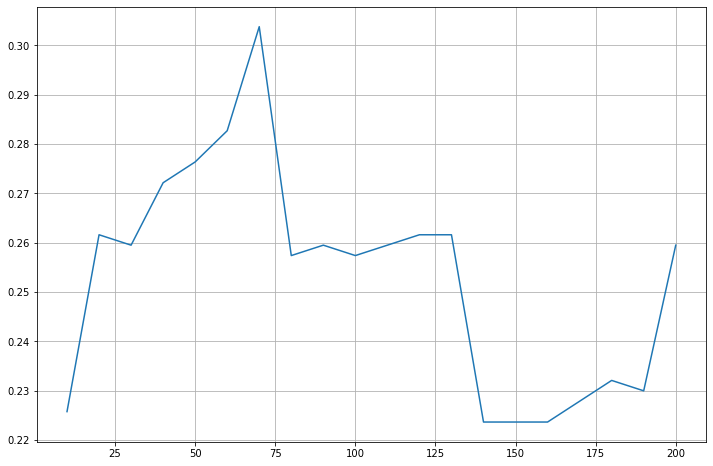

In [ ]:
plt.figure(figsize=(12,8))  
plt.plot(rank_list,AllHitr_)   ###Max == 70
plt.grid()

# Updated PSI

**Get Updated Mat**

In [ ]:
rows_i = AllDF_start['userId'].nunique()
cols_i = AllDF_start['productId'].nunique()
print(A0_df.shape)
A0_RatMat_updt = SingleRatingMatrix(A0_df,'userId', 'productId',rows_i,cols_i)
A0_RatMat_updt

(30661, 5)


<19169x6515 sparse matrix of type '<class 'numpy.float64'>'
	with 30415 stored elements in Compressed Sparse Row format>

In [ ]:
PSI_TrainMat_updt = AllRatingMatrices(ΔA_train,'userId','productId',rows_i ,cols_i)
PSI_TrainMat_updt

[<19169x6515 sparse matrix of type '<class 'numpy.float64'>'
 	with 1197 stored elements in Compressed Sparse Row format>,
 <19169x6515 sparse matrix of type '<class 'numpy.float64'>'
 	with 1199 stored elements in Compressed Sparse Row format>,
 <19169x6515 sparse matrix of type '<class 'numpy.float64'>'
 	with 1197 stored elements in Compressed Sparse Row format>,
 <19169x6515 sparse matrix of type '<class 'numpy.float64'>'
 	with 1199 stored elements in Compressed Sparse Row format>,
 <19169x6515 sparse matrix of type '<class 'numpy.float64'>'
 	with 1199 stored elements in Compressed Sparse Row format>,
 <19169x6515 sparse matrix of type '<class 'numpy.float64'>'
 	with 1200 stored elements in Compressed Sparse Row format>,
 <19169x6515 sparse matrix of type '<class 'numpy.float64'>'
 	with 1200 stored elements in Compressed Sparse Row format>,
 <19169x6515 sparse matrix of type '<class 'numpy.float64'>'
 	with 1200 stored elements in Compressed Sparse Row format>]

**Allsteps Update**

In [ ]:
U_start,S_start,V_start = last_psiTrainMat(A0_RatMat_updt,PSI_TrainMat_updt,k=70)
print()
print("U_start shape: ",U_start.shape)
print("S_start shape: ",S_start.shape)
print("V_start shape: ",V_start.shape)

100%|██████████| 8/8 [00:00<00:00, 20.83it/s]
U_start shape:  (19169, 70)
S_start shape:  (70, 70)
V_start shape:  (6515, 70)



In [ ]:
U_list,S_list,V_list = [],[],[]
U_list.append(U_start)
S_list.append(S_start)
V_list.append(V_start)
print(len(U_list),len(V_list))

1 1


In [ ]:
DItems_, DUsers_,In_DomainUSERS,In_DomainITEMS,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,U_list,S_list,V_list = ALLSTEPs_UPDATE(AllDF_start,UserItemDF_list,New_itemsList,New_usersList,U_list,S_list,V_list,'userId','productId',Nsteps=10,k=70,Forced_Orth=False)

100%|██████████| 9/9 [01:59<00:00, 13.29s/it]


**Output Check**

In [ ]:
print(AllDF_start['productId'].max())
print(AllDF_start['userId'].max())

6514
19168


In [ ]:
print(len(In_DomainITEMS[6514+1:]))
print(In_DomainITEMS[6514+1:][:10])
print()
print(len(In_DomainUSERS[19168+1:]))
print(In_DomainUSERS[19168+1:][:10])

1594
[6515, 6516, 6526, 6530, 6550, 6552, 6586, 6588, 6598, 6619]

3388
[19169, 19170, 19172, 19176, 19177, 19178, 19180, 19182, 19183, 19185]


In [ ]:
#deferred items and users
print(len(DItems_))
print(DItems_[:10])
print()
print(len(DUsers_))
print(DUsers_[:10])

511
[8486, 8487, 8488, 8489, 8490, 8491, 8492, 8493, 8494, 8495]

242
[22646, 22651, 22653, 22659, 22661, 22676, 22677, 22706, 22729, 22733]


In [ ]:
for x in list(itemID_dict)[6514+1:][:100]:
    print ("Id: {}, UpdtId: {} ".format(x,  itemID_dict[x]))   ##id ==key || updtedid == values  ,itemID_dict

Id: 6515, UpdtId: 6515 
Id: 6516, UpdtId: 6516 
Id: 6526, UpdtId: 6517 
Id: 6530, UpdtId: 6518 
Id: 6550, UpdtId: 6519 
Id: 6552, UpdtId: 6520 
Id: 6586, UpdtId: 6521 
Id: 6588, UpdtId: 6522 
Id: 6598, UpdtId: 6523 
Id: 6619, UpdtId: 6524 
Id: 6620, UpdtId: 6525 
Id: 6630, UpdtId: 6526 
Id: 6632, UpdtId: 6527 
Id: 6645, UpdtId: 6528 
Id: 6661, UpdtId: 6529 
Id: 6662, UpdtId: 6530 
Id: 6666, UpdtId: 6531 
Id: 6578, UpdtId: 6532 
Id: 6579, UpdtId: 6533 
Id: 6621, UpdtId: 6534 
Id: 6679, UpdtId: 6535 
Id: 6778, UpdtId: 6536 
Id: 6792, UpdtId: 6537 
Id: 6803, UpdtId: 6538 
Id: 6815, UpdtId: 6539 
Id: 6830, UpdtId: 6540 
Id: 6844, UpdtId: 6541 
Id: 6881, UpdtId: 6542 
Id: 6518, UpdtId: 6543 
Id: 6520, UpdtId: 6544 
Id: 6524, UpdtId: 6545 
Id: 6533, UpdtId: 6546 
Id: 6534, UpdtId: 6547 
Id: 6539, UpdtId: 6548 
Id: 6542, UpdtId: 6549 
Id: 6543, UpdtId: 6550 
Id: 6544, UpdtId: 6551 
Id: 6545, UpdtId: 6552 
Id: 6549, UpdtId: 6553 
Id: 6553, UpdtId: 6554 
Id: 6557, UpdtId: 6555 
Id: 6558, UpdtId

In [ ]:
for x in list(userID_dict)[19169:][:100]:
    print ("Id: {}, UpdtId: {} ".format(x,  userID_dict[x]))   ##id ==key || updtedid == values 

Id: 19169, UpdtId: 19169 
Id: 19170, UpdtId: 19170 
Id: 19172, UpdtId: 19171 
Id: 19176, UpdtId: 19172 
Id: 19177, UpdtId: 19173 
Id: 19178, UpdtId: 19174 
Id: 19180, UpdtId: 19175 
Id: 19182, UpdtId: 19176 
Id: 19183, UpdtId: 19177 
Id: 19185, UpdtId: 19178 
Id: 19186, UpdtId: 19179 
Id: 19193, UpdtId: 19180 
Id: 19194, UpdtId: 19181 
Id: 19196, UpdtId: 19182 
Id: 19197, UpdtId: 19183 
Id: 19198, UpdtId: 19184 
Id: 19201, UpdtId: 19185 
Id: 19202, UpdtId: 19186 
Id: 19203, UpdtId: 19187 
Id: 19209, UpdtId: 19188 
Id: 19210, UpdtId: 19189 
Id: 19212, UpdtId: 19190 
Id: 19217, UpdtId: 19191 
Id: 19220, UpdtId: 19192 
Id: 19223, UpdtId: 19193 
Id: 19224, UpdtId: 19194 
Id: 19226, UpdtId: 19195 
Id: 19230, UpdtId: 19196 
Id: 19232, UpdtId: 19197 
Id: 19234, UpdtId: 19198 
Id: 19235, UpdtId: 19199 
Id: 19236, UpdtId: 19200 
Id: 19238, UpdtId: 19201 
Id: 19240, UpdtId: 19202 
Id: 19242, UpdtId: 19203 
Id: 19245, UpdtId: 19204 
Id: 19250, UpdtId: 19205 
Id: 19251, UpdtId: 19206 
Id: 19254, U

In [ ]:
print(len(U_list),len(V_list))
print(U_list[0].shape,V_list[0].shape)
print()
for u,v in zip(U_list[1:],V_list[1:]):
    print(u.shape,v.shape)   

11 11
(19169, 70) (6515, 70)

(19386, 70) (6537, 70)
(19763, 70) (6694, 70)
(20149, 70) (6873, 70)
(20538, 70) (7034, 70)
(20916, 70) (7224, 70)
(21244, 70) (7428, 70)
(21630, 70) (7645, 70)
(21959, 70) (7748, 70)
(22315, 70) (7914, 70)
(22557, 70) (8109, 70)


In [ ]:
for i,j in zip(AllUpdtUSERS_,AllUpdtITEMS_):
    print(len(i),len(j))

19386 6537
19763 6694
20149 6873
20538 7034
20916 7224
21244 7428
21630 7645
21959 7748
22315 7914
22557 8109


In [ ]:
print(len(In_DomainUSERS),len(In_DomainITEMS))
print(AMZB_DF['userId'].nunique(),AMZB_DF['productId'].nunique())

22557 8109
22799 8620


**Data Adjustments**

In [ ]:
len(AllUpdtITEMS_)

10

In [ ]:

newHOLDOUT_LIST = get_NEWHoldout(HOLDOUT_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
print(len(newHOLDOUT_LIST))
print()
for old,new in zip(HOLDOUT_list,newHOLDOUT_LIST):
    print(old.shape[0],new.shape[0])

10it [00:00, 111.49it/s]10

829 474
801 433
811 465
812 478
820 478
868 508
787 612
847 599
789 536
580 425



In [ ]:
newUserItem_list = adjustedAllDF(UserItemDF_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
print()
for df in newUserItem_list:
    print(df['Updated_UserID'].max(),df['Updated_ItemID'].max())

10it [00:00, 16.81it/s]
19385 6536
19762 6693
20148 6872
20537 7033
20915 7223
21243 7427
21629 7644
21958 7747
22314 7913
22556 8108



In [ ]:
new_PSIDFlist = adjustedPSI_DF(PSITest_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
for old,new in zip(PSITest_list,new_PSIDFlist):
    print(old.shape[0],new.shape[0])

10it [00:00, 130.43it/s]371 324
399 343
389 347
388 338
380 338
332 292
413 397
353 323
411 365
228 203



In [ ]:
newAMZB_DF = ADJUST_mainDF(AMZB_DF,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
print(newAMZB_DF.shape)
print(newAMZB_DF['userId'].max(),newAMZB_DF['productId'].max())
print(newAMZB_DF['userId'].nunique(),newAMZB_DF['productId'].nunique())
print()
print(newAMZB_DF['Updated_UserID'].max(),newAMZB_DF['Updated_ItemID'].max())
print(newAMZB_DF['Updated_UserID'].nunique(),newAMZB_DF['Updated_ItemID'].nunique())
#newAMZB_DF.head()

(51277, 7)
22797 8611
22557 8109

22556 8108
22557 8109


In [ ]:
import pickle
with open('AMZB_newUserItem.pkl', 'wb') as f:
     pickle.dump(newUserItem_list, f)

with open('AMZB_newHoldout.pkl', 'wb') as f:
     pickle.dump(newHOLDOUT_LIST, f)     

with open('AMZB_newPSITest.pkl', 'wb') as f:
     pickle.dump(new_PSIDFlist, f)     

newAMZB_DF.to_csv('AMZB_newDF.csv',index=False)     

In [ ]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZB_newUserItem.pkl', 'rb') as f:
     newUserItem_l = pickle.load(f)


**Get UserItem MAT**

In [ ]:
for i in range(10):
    print(newUserItem_list[i]['Updated_UserID'].max(),newUserItem_list[i]['Updated_ItemID'].max())

19385 6536
19762 6693
20148 6872
20537 7033
20915 7223
21243 7427
21629 7644
21958 7747
22314 7913
22556 8108


In [ ]:
print(len(U_list[1:]),len(V_list[1:]))
for u,v in zip(U_list[1:],V_list[1:]):
    print(u.shape[0],v.shape[0])   

10 10
19386 6537
19763 6694
20149 6873
20538 7034
20916 7224
21244 7428
21630 7645
21959 7748
22315 7914
22557 8109


In [ ]:
UserItem_Matupdt = AllSingleStepRatMat_2(newUserItem_list,'Updated_UserID','Updated_ItemID')
print(len(UserItem_Matupdt))
UserItem_Matupdt

10


[<19386x6537 sparse matrix of type '<class 'numpy.float64'>'
 	with 40228 stored elements in Compressed Sparse Row format>,
 <19763x6694 sparse matrix of type '<class 'numpy.float64'>'
 	with 41330 stored elements in Compressed Sparse Row format>,
 <20149x6873 sparse matrix of type '<class 'numpy.float64'>'
 	with 42432 stored elements in Compressed Sparse Row format>,
 <20538x7034 sparse matrix of type '<class 'numpy.float64'>'
 	with 43525 stored elements in Compressed Sparse Row format>,
 <20916x7224 sparse matrix of type '<class 'numpy.float64'>'
 	with 44665 stored elements in Compressed Sparse Row format>,
 <21244x7428 sparse matrix of type '<class 'numpy.float64'>'
 	with 45752 stored elements in Compressed Sparse Row format>,
 <21630x7645 sparse matrix of type '<class 'numpy.float64'>'
 	with 47034 stored elements in Compressed Sparse Row format>,
 <21959x7748 sparse matrix of type '<class 'numpy.float64'>'
 	with 48112 stored elements in Compressed Sparse Row format>,
 <22315x

In [ ]:
print(AllDF_start['userId'].nunique(),AllDF_start['productId'].nunique())
print()
for i,j in zip(AllUpdtUSERS_,AllUpdtITEMS_):
    print(len(i),len(j))

19169 6515

19386 6537
19763 6694
20149 6873
20538 7034
20916 7224
21244 7428
21630 7645
21959 7748
22315 7914
22557 8109


## HitRate

In [ ]:
print(len(UserItem_Matupdt),len(newHOLDOUT_LIST))

10 10


In [ ]:
Vpsi_listUpdt = V_list[1:]
for v in Vpsi_listUpdt:
    print(v.shape)

(6537, 70)
(6694, 70)
(6873, 70)
(7034, 70)
(7224, 70)
(7428, 70)
(7645, 70)
(7748, 70)
(7914, 70)
(8109, 70)


In [ ]:
V_1 = Vpsi_listUpdt[0]
V_1.shape

(6537, 70)

In [ ]:
Top_NPred = TopNPred(UserItem_Matupdt[0],newHOLDOUT_LIST[0],V_1,'Updated_UserID',10)
Top_NPred

array([[ 558,   22,  995, ...,  488,   66, 4323],
       [ 360, 1283,  185, ..., 1012,  928,  242],
       [ 389,  598,  723, ...,   82,  804, 1310],
       ...,
       [ 251,  239, 1566, ...,  499, 1247, 1967],
       [ 319,  815,  422, ...,  420,  588, 3373],
       [ 369,  420, 1120, ...,   74, 1283,  694]])

In [ ]:
Hitrate_Eval(newHOLDOUT_LIST[0],Top_NPred,'Updated_UserID','Updated_ItemID')

Number of hits:  127
Total Num of users:  474
Recommendation HitRate:  0.2679324894514768


0.2679324894514768

In [ ]:
AllUpdt_pred =  TQDMgetALLTopNPred(UserItem_Matupdt,newHOLDOUT_LIST,Vpsi_listUpdt,'Updated_UserID',N = 10)
print(len(AllUpdt_pred))
AllUpdt_pred[:2]

10it [00:00, 16.15it/s]10



[array([[ 558,   22,  995, ...,  488,   66, 4323],
        [ 360, 1283,  185, ..., 1012,  928,  242],
        [ 389,  598,  723, ...,   82,  804, 1310],
        ...,
        [ 251,  239, 1566, ...,  499, 1247, 1967],
        [ 319,  815,  422, ...,  420,  588, 3373],
        [ 369,  420, 1120, ...,   74, 1283,  694]]),
 array([[ 389,  598,  723, ...,   82,  804, 1310],
        [1283,  694,  231, ...,  965, 1012,  789],
        [  86,   92,  272, ..., 1947, 5594,    5],
        ...,
        [ 311,  129,   85, ...,   92,  242,  272],
        [ 427, 1435,  635, ..., 6626,  191, 6661],
        [  74, 2255,  231, ..., 1307, 2645,  460]])]

In [ ]:
AllSteps_HitR_updt, LowerBand_updt, Avg_HitR_updt, UpperBand_updt   = getAll_HitRate(newHOLDOUT_LIST,AllUpdt_pred,'Updated_UserID','Updated_ItemID')

Number of hits:  127
Total Num of users:  474
Recommendation HitRate:  0.2679324894514768
Number of hits:  149
Total Num of users:  433
Recommendation HitRate:  0.3441108545034642
Number of hits:  156
Total Num of users:  465
Recommendation HitRate:  0.33548387096774196
Number of hits:  146
Total Num of users:  478
Recommendation HitRate:  0.3054393305439331
Number of hits:  136
Total Num of users:  478
Recommendation HitRate:  0.28451882845188287
Number of hits:  139
Total Num of users:  508
Recommendation HitRate:  0.2736220472440945
Number of hits:  174
Total Num of users:  612
Recommendation HitRate:  0.28431372549019607
Number of hits:  151
Total Num of users:  599
Recommendation HitRate:  0.25208681135225375
Number of hits:  162
Total Num of users:  536
Recommendation HitRate:  0.30223880597014924
Number of hits:  58
Total Num of users:  425
Recommendation HitRate:  0.13647058823529412
Average HitRate for All Recommendations:  0.2786217352210487


In [ ]:
AllSteps_HitR_updt

[0.2679324894514768,
 0.3441108545034642,
 0.33548387096774196,
 0.3054393305439331,
 0.28451882845188287,
 0.2736220472440945,
 0.28431372549019607,
 0.25208681135225375,
 0.30223880597014924,
 0.13647058823529412]

In [ ]:
##MRR Test

## MRR

In [ ]:
mrr_1st = MRR_Eval(newHOLDOUT_LIST[0],Top_NPred,'Updated_ItemID')
print("1st Step MRR: ",mrr_1st)

1st Step MRR:  0.24122714486638538


In [ ]:
AllSteps_MRRUpdt, LowerB_Updt, AvgMRR_Updt, UpperB_Updt  = TQDMgetAll_MRR_Eval(newHOLDOUT_LIST,AllUpdt_pred,'Updated_ItemID')
AllSteps_MRRUpdt    ##Rank ==70

10it [00:00, 1120.93it/s]


[0.241227,
 0.298919,
 0.311335,
 0.271502,
 0.260327,
 0.245122,
 0.205629,
 0.215582,
 0.259141,
 0.113294]

In [ ]:
print("Average MRR: ",AvgMRR_Updt)

Average MRR:  0.242208


## Allusers Preds

In [ ]:
##All Prediction

In [ ]:
print(UserItem_Matupdt[0].shape)
UserItem_Matupdt[0]

(19386, 6537)


<19386x6537 sparse matrix of type '<class 'numpy.float64'>'
	with 40228 stored elements in Compressed Sparse Row format>

In [ ]:
AllUsers_updtPRED =  TQDMgetALLTopNPred_ALLUSERS(UserItem_Matupdt,Vpsi_listUpdt, N=10) 
print(len(AllUsers_updtPRED))
AllUsers_updtPRED[:2]

10it [00:23,  2.39s/it]10



[array([[ 133,   71,  134, ...,   57,  139,  216],
        [  60,  297,  133, ...,  242,  245,   63],
        [ 297,  242,  424, ...,  199,  357,  595],
        ...,
        [ 251,  239, 1566, ...,  499, 1247, 1967],
        [ 319,  815,  422, ...,  420,  588, 3373],
        [ 369,  420, 1120, ...,   74, 1283,  694]]),
 array([[ 133,   71,  134, ...,   57,  139,  216],
        [  60,  297,  133, ...,  242,  245,   63],
        [ 297,  242,  424, ...,  199,  357,  595],
        ...,
        [ 694,   83,  416, ...,  105,  800,  757],
        [ 239,  815,   25, ..., 1826, 3030,  551],
        [ 558,  717, 1203, ...,  124, 3026,  474]])]

In [ ]:
AllUsers_updtPRED[2].shape

(20149, 10)

In [ ]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_UpdtPSI_AllPRED.pkl', 'wb') as f:
     pickle.dump(AllUsers_updtPRED, f)

## Coverage

In [ ]:
StepCoverage_Ratio(newAMZB_DF,AllUsers_updtPRED[0],'Updated_ItemID')

0.079911

In [ ]:
UpdtAvg_Coverage_List = AllSteps_Coverage_Ratio(newAMZB_DF,AllUsers_updtPRED,'Updated_ItemID')
UpdtAvg_Coverage_List

[0.079911,
 0.081884,
 0.083364,
 0.084351,
 0.083981,
 0.083118,
 0.083487,
 0.082008,
 0.082131,
 0.082871]

## Stability

In [ ]:
AllSteps = list(range(1,10))
print(len(AllSteps))
print(len(AllUsers_updtPRED))
AllSteps

9
10


[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
UpdtPSICorr_ = Updt_getAll_AvgCorr(AllUsers_updtPRED,newUserItem_list,AllSteps,'Updated_UserID')  #,
UpdtPSICorr_

array([array([1.        , 1.        , 1.        , ..., 0.        , 0.02499653,
              0.        ])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.38792779, 0.67845367,
              0.        ])                                                    ,
       array([0.98387314, 1.        , 1.        , ..., 0.        , 0.        ,
              0.        ])                                                    ,
       array([0.98387314, 0.94467132, 1.        , ..., 0.86813465, 0.4539545 ,
              0.        ])                                                    ,
       array([0.97749498, 0.9226361 , 1.        , ..., 0.49096051, 0.23150079,
              0.33050924])                                                    ,
       array([1.        , 1.        , 0.98387314, ..., 0.02499653, 0.08321104,
              0.        ])                                                    ,
       array([0.99056095, 1.        , 1.      

In [ ]:
print(UpdtPSICorr_.shape)
print()
for df in UpdtPSICorr_:
    print(df.mean())  

(9,)

0.9507462669864827
0.9541200786395395
0.9462585543316474
0.954978187309988
0.9558312089585588
0.9507349839638036
0.9493731138244673
0.9385440611135092
0.9621093635351206


# Regular PSI 

**Get Rating Matrices**

In [ ]:
print(newAMZB_DF.shape)
print(newAMZB_DF['userId'].max(),newAMZB_DF['productId'].max())
print(newAMZB_DF['userId'].nunique(),newAMZB_DF['productId'].nunique())
print()
print(newAMZB_DF['Updated_UserID'].max(),newAMZB_DF['Updated_ItemID'].max())
print(newAMZB_DF['Updated_UserID'].nunique(),newAMZB_DF['Updated_ItemID'].nunique())
newAMZB_DF.head()

(51277, 7)
22797 8611
22557 8109

22556 8108
22557 8109


,userId,productId,rating,timestamp,timestamp_YM,Updated_UserID,Updated_ItemID
0,0,0,1,2001-06-08,2001-06,0,0
1,1,0,1,2002-06-12,2002-06,1,0
2,1,1,1,2002-06-12,2002-06,1,1
3,2,1,1,2002-06-17,2002-06,2,1
4,3,1,1,2002-07-04,2002-07,3,1


In [ ]:
rows_i = newAMZB_DF['Updated_UserID'].nunique()
cols_i = newAMZB_DF['Updated_ItemID'].nunique()
print(A0_df.shape)
A0_Rating_matrix = SingleRatingMatrix(A0_df,'userId', 'productId',rows_i,cols_i)  ##changes start within steps...
A0_Rating_matrix

(30661, 5)


<22557x8109 sparse matrix of type '<class 'numpy.float64'>'
	with 30415 stored elements in Compressed Sparse Row format>

In [ ]:
for df in new_PSIDFlist:
    print(df['Updated_UserID'].max(),df['Updated_ItemID'].max())

19385 6536
19747 6674
20140 6837
20537 6998
20915 7178
21216 7383
21628 7579
21948 7742
22314 7866
22502 8041


In [ ]:
print("Length of PSI_Train :",len(ΔA_train))
print("Length of PSI_Test  :",len(new_PSIDFlist))  

Length of PSI_Train : 8
Length of PSI_Test  : 10


In [ ]:
PSI_train_matrix = AllRatingMatrices(ΔA_train,'userId','productId',rows_i ,cols_i)
PSI_train_matrix   

[<22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 1197 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 1199 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 1197 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 1199 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 1199 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 1200 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 1200 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 1200 stored elements in Compressed Sparse Row format>]

In [ ]:
PSI_test_matrix = AllRatingMatrices(new_PSIDFlist,'Updated_UserID','Updated_ItemID',rows_i ,cols_i)                                                                      
print(len(PSI_test_matrix))
PSI_test_matrix

10


[<22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 324 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 343 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 347 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 338 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 338 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 292 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 395 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 323 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matr

In [ ]:
UserItemMAT_regPSI = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) 
UserItemMAT_regPSI  

[<22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 40228 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 41330 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 42432 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 43525 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 44665 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 45752 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 47034 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 48112 stored elements in Compressed Sparse Row format>,
 <22557x

In [ ]:
print(AllDF_list[-1]['userId'].nunique(),AllDF_list[-1]['productId'].nunique())
print(AMZB_DF['userId'].nunique(),AMZB_DF['productId'].nunique())

22799 8620
22799 8620


## HitRate

In [ ]:
Vpsi_listReg =  integratorOnMat(A0_Rating_matrix,PSI_train_matrix,PSI_test_matrix,k=70)  #PSI
print(len(Vpsi_listReg))  ##Rank==70

10


In [ ]:
Top10Pred_psi = TopNPred(UserItemMAT_regPSI[0], newHoldout_list[0],Vpsi_listReg[0],'Updated_UserID',N=10)
print(Top10Pred_psi.shape)
Top10Pred_psi  

(474, 10)


array([[ 558,   22,  995, ...,  488,   66, 4323],
       [ 360, 1283,  185, ...,  789,  928,  242],
       [ 389,  598,  723, ...,   82,  804, 1310],
       ...,
       [ 251,  239, 1566, ...,  499, 1247, 1967],
       [ 319,  815,  422, ...,  854, 1412, 4005],
       [ 369,  420, 1120, ...,  694,  144, 1076]])

In [ ]:
Hitrate_Eval(newHoldout_list[0],Top10Pred_psi,'Updated_UserID','Updated_ItemID')

Number of hits:  127
Total Num of users:  474
Recommendation HitRate:  0.2679324894514768


0.2679324894514768

In [ ]:
All_regPSI_PRED =  TQDMgetALLTopNPred(UserItemMAT_regPSI,newHoldout_list,Vpsi_listReg,'Updated_UserID',N = 10)
print(len(All_regPSI_PRED))
All_regPSI_PRED[:2]

10it [00:00, 13.53it/s]10



[array([[ 558,   22,  995, ...,  488,   66, 4323],
        [ 360, 1283,  185, ...,  789,  928,  242],
        [ 389,  598,  723, ...,   82,  804, 1310],
        ...,
        [ 251,  239, 1566, ...,  499, 1247, 1967],
        [ 319,  815,  422, ...,  854, 1412, 4005],
        [ 369,  420, 1120, ...,  694,  144, 1076]]),
 array([[ 389,  598,  723, ...,   82,  804, 1310],
        [1283,  694,  231, ...,  965, 1012,  789],
        [  86,   92,  272, ..., 1947, 5594,    5],
        ...,
        [ 311,  129,   85, ...,  242,  272, 1385],
        [ 427, 1435,  635, ..., 2043,  582, 1401],
        [  74, 2255,  231, ..., 1307, 2645,  460]])]

In [ ]:
AllSteps_Hitrate_psi, LowerBand, Avg_HitRate, UpperBand   = getAll_HitRate(newHoldout_list,All_regPSI_PRED,'Updated_UserID','Updated_ItemID')

Number of hits:  127
Total Num of users:  474
Recommendation HitRate:  0.2679324894514768
Number of hits:  148
Total Num of users:  433
Recommendation HitRate:  0.3418013856812933
Number of hits:  157
Total Num of users:  465
Recommendation HitRate:  0.33763440860215055
Number of hits:  144
Total Num of users:  478
Recommendation HitRate:  0.301255230125523
Number of hits:  135
Total Num of users:  478
Recommendation HitRate:  0.2824267782426778
Number of hits:  139
Total Num of users:  508
Recommendation HitRate:  0.2736220472440945
Number of hits:  168
Total Num of users:  612
Recommendation HitRate:  0.27450980392156865
Number of hits:  149
Total Num of users:  599
Recommendation HitRate:  0.24874791318864775
Number of hits:  165
Total Num of users:  536
Recommendation HitRate:  0.30783582089552236
Number of hits:  61
Total Num of users:  425
Recommendation HitRate:  0.14352941176470588
Average HitRate for All Recommendations:  0.27792952891176614


In [ ]:
AllSteps_Hitrate_psi  #Rank ==70

[0.2679324894514768,
 0.3418013856812933,
 0.33763440860215055,
 0.301255230125523,
 0.2824267782426778,
 0.2736220472440945,
 0.27450980392156865,
 0.24874791318864775,
 0.30783582089552236,
 0.14352941176470588]

## MRR 

In [ ]:
##MRR: 
mrr_psi_1st = MRR_Eval(newHoldout_list[0],Top10Pred_psi,'Updated_ItemID')
print("1st Step MRR: ",mrr_psi_1st)

1st Step MRR:  0.2394188266023709


In [ ]:
psi_AllStepsMRR, psi_LowerB, psi_AvgMRR, psi_UpperB  = TQDMgetAll_MRR_Eval(newHoldout_list,All_regPSI_PRED,'Updated_ItemID')
psi_AllStepsMRR  

10it [00:00, 805.02it/s]


[0.239419,
 0.29641,
 0.312709,
 0.2697,
 0.260157,
 0.243877,
 0.211119,
 0.219799,
 0.259858,
 0.116059]

In [ ]:
print("Average MRR: ",psi_AvgMRR)

Average MRR:  0.242911


## AllUsers Pred

In [ ]:
### Get All Prediction

In [ ]:
AllUsersRegPIS_PRED =  TQDMgetALLTopNPred_ALLUSERS(UserItemMAT_regPSI,Vpsi_listReg, N=10) 
print(len(AllUsersRegPIS_PRED))
AllUsersRegPIS_PRED[:2]

10it [00:28,  2.89s/it]10



[array([[ 133,   71,  134, ...,   57,  139,  216],
        [  60,  297,  133, ...,  242,  245,   63],
        [ 297,  242,  424, ...,  199,  357,  595],
        ...,
        [2702, 2699, 2695, ..., 2705, 2706, 8108],
        [2702, 2699, 2695, ..., 2705, 2706, 8108],
        [2702, 2699, 2695, ..., 2705, 2706, 8108]]),
 array([[ 133,   71,  134, ...,   57,  139,  216],
        [  60,  297,  133, ...,  242,  245,   63],
        [ 297,  242,  424, ...,  199,  357,  595],
        ...,
        [2702, 2699, 2695, ..., 2705, 2706, 8108],
        [2702, 2699, 2695, ..., 2705, 2706, 8108],
        [2702, 2699, 2695, ..., 2705, 2706, 8108]])]

In [ ]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_PSI_AllPRED.pkl', 'wb') as f:
     pickle.dump(AllUsersRegPIS_PRED, f)


In [ ]:
AllUsersRegPIS_PRED[2].shape

(22557, 10)

## Coverage

In [ ]:
psi_AvgCoverage_List = AllSteps_Coverage_Ratio(newAMZB_DF,AllUsersRegPIS_PRED,'Updated_ItemID')
psi_AvgCoverage_List   #Rank ==70

[0.079788,
 0.080035,
 0.080281,
 0.080035,
 0.079295,
 0.078925,
 0.078308,
 0.078678,
 0.077568,
 0.076458]

## Stability

In [ ]:
AllSteps = list(range(1,10))
print(len(AllSteps))
print(len(AllUsers_updtPRED))
AllSteps  

9
10


[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
RegPSICorr_ = Updt_getAll_AvgCorr(AllUsersRegPIS_PRED,newUserItem_list,AllSteps,'Updated_UserID')  #,
RegPSICorr_

array([array([1.        , 1.        , 1.        , ..., 0.        , 0.02180383,
              0.        ])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.49096051, 0.67845367,
              0.        ])                                                    ,
       array([1., 1., 1., ..., 0., 0., 0.]),
       array([1.        , 0.94467132, 1.        , ..., 0.86813465, 0.49096051,
              0.        ])                                                    ,
       array([1.        , 0.98788042, 1.        , ..., 0.41493338, 0.15058457,
              0.33050924])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.02180383, 0.08321104,
              0.        ])                                                    ,
       array([0.97749498, 1.        , 1.        , ..., 0.        , 0.        ,
              0.        ])                                                    ,
 

In [ ]:
print(RegPSICorr_.shape)
print()
for df in RegPSICorr_:  ##Rank == 70
    print(df.mean())  

(9,)

0.9650199240782822
0.9654632087140693
0.9695926766281905
0.9686051221346264
0.9527405218684136
0.9601414867533916
0.9622915047414743
0.9439463379000846
0.9700566762443715


# Pure SVD

**Get Rating Matrices**

In [ ]:
import pickle

with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_newHoldout.pkl', 'rb') as f:
     newHoldout_list = pickle.load(f)     
    
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_newUserItem.pkl', 'rb') as f:
     newUserItem_list = pickle.load(f)

with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_newPSITest.pkl', 'rb') as f:
     newPSIDF_LIST = pickle.load(f)

In [ ]:
for df in newPSIDF_LIST:
    print(df.shape[0])

324
343
347
338
338
292
397
323
365
203


In [ ]:
newHoldout_list[0].columns

Index(['userId', 'productId', 'Updated_UserID', 'Updated_ItemID'], dtype='object')

In [ ]:
for df in newHoldout_list:
    print(df['Updated_UserID'].nunique(),df.shape[0])

474 474
433 433
465 465
478 478
478 478
508 508
612 612
599 599
536 536
425 425


In [ ]:
rows_i = newAMZB_DF['Updated_UserID'].nunique()
cols_i = newAMZB_DF['Updated_ItemID'].nunique()
SVD_UserItemMAT = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) ##Same as UserItemMAT_regPSI
SVD_UserItemMAT

[<22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 40228 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 41330 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 42432 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 43525 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 44665 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 45752 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 47034 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 48112 stored elements in Compressed Sparse Row format>,
 <22557x

In [ ]:
##Best Rank==70

## HitRate

In [ ]:
Vsvd_list = pureSVD(SVD_UserItemMAT,k=70)
print(len(Vsvd_list))

10


In [ ]:
Vsvd_last = Vsvd_list[-1]
Vsvd_last

array([[ 2.52465830e-06, -2.39704886e-04,  1.03121346e-03, ...,
         5.48022918e-10,  8.84752319e-10, -3.54033696e-08],
       [ 2.62720207e-05, -1.45760305e-05, -5.36633086e-04, ...,
        -2.47271955e-10,  6.68028386e-10, -2.82444440e-08],
       [-1.45282062e-04,  5.95159440e-04,  7.69668168e-04, ...,
         1.49198330e-07,  3.52620464e-07, -2.67741390e-07],
       ...,
       [ 1.91234867e-07, -1.55406575e-06,  5.54581134e-07, ...,
         2.87645739e-13,  8.51731986e-15, -3.67450004e-16],
       [ 1.95433367e-09, -5.44213811e-08,  4.74408769e-08, ...,
        -4.97039610e-17, -1.88676733e-16, -5.14630231e-18],
       [-9.56958812e-05,  8.02592590e-04,  5.97933171e-06, ...,
        -2.09547368e-10,  3.36571072e-10, -1.68180004e-11]])

In [ ]:
Top10Pred_SVD = TopNPred(SVD_UserItemMAT[0],newHoldout_list[0],Vsvd_list[0],'Updated_UserID',N=10)
print(Top10Pred_SVD.shape)
Top10Pred_SVD  

(474, 10)


array([[ 558,   22,  995, ..., 3666,  488,  328],
       [4017, 1283, 2255, ..., 2736,  194, 4401],
       [ 389,  133,  598, ..., 1034,   82, 1310],
       ...,
       [ 251,  239, 1566, ...,  499, 1247, 1967],
       [ 319,  815,  422, ...,  588,  416,  854],
       [ 369,  158, 1628, ...,  328,  566,  219]])

In [ ]:
Hitrate_Eval(newHoldout_list[0],Top10Pred_SVD,'Updated_UserID','Updated_ItemID')

Number of hits:  141
Total Num of users:  474
Recommendation HitRate:  0.2974683544303797


0.2974683544303797

In [ ]:
AllSVD_topNPRED =  TQDMgetALLTopNPred(SVD_UserItemMAT,newHoldout_list,Vsvd_list,'Updated_UserID',N = 10)
print(len(AllSVD_topNPRED))
AllSVD_topNPRED[:2]

10it [00:00, 12.70it/s]10



[array([[ 558,   22,  995, ..., 3666,  488,  328],
        [4017, 1283, 2255, ..., 2736,  194, 4401],
        [ 389,  133,  598, ..., 1034,   82, 1310],
        ...,
        [ 251,  239, 1566, ...,  499, 1247, 1967],
        [ 319,  815,  422, ...,  588,  416,  854],
        [ 369,  158, 1628, ...,  328,  566,  219]]),
 array([[ 389,  133,  598, ...,   82, 1034, 1310],
        [ 231,  523, 1260, ..., 3026,  225,  226],
        [ 439,  922,  523, ...,   41,  191,  297],
        ...,
        [ 311,   85, 1230, ..., 2067, 3433, 4714],
        [ 427, 6134, 1435, ..., 2043, 1401, 6386],
        [  74, 2255,  231, ..., 3545, 2645,  566]])]

In [ ]:
AllSteps_Hitrate_svd, LowerBand, Avg_HitRate, UpperBand   = getAll_HitRate(newHoldout_list,AllSVD_topNPRED,'Updated_UserID','Updated_ItemID')

Number of hits:  141
Total Num of users:  474
Recommendation HitRate:  0.2974683544303797
Number of hits:  139
Total Num of users:  433
Recommendation HitRate:  0.3210161662817552
Number of hits:  148
Total Num of users:  465
Recommendation HitRate:  0.31827956989247314
Number of hits:  152
Total Num of users:  478
Recommendation HitRate:  0.3179916317991632
Number of hits:  148
Total Num of users:  478
Recommendation HitRate:  0.30962343096234307
Number of hits:  152
Total Num of users:  508
Recommendation HitRate:  0.2992125984251969
Number of hits:  204
Total Num of users:  612
Recommendation HitRate:  0.3333333333333333
Number of hits:  164
Total Num of users:  599
Recommendation HitRate:  0.27378964941569284
Number of hits:  180
Total Num of users:  536
Recommendation HitRate:  0.3358208955223881
Number of hits:  81
Total Num of users:  425
Recommendation HitRate:  0.19058823529411764
Average HitRate for All Recommendations:  0.29971238653568427


In [ ]:
AllSteps_Hitrate_svd  ##Rank == 70

[0.2974683544303797,
 0.3210161662817552,
 0.31827956989247314,
 0.3179916317991632,
 0.30962343096234307,
 0.2992125984251969,
 0.3333333333333333,
 0.27378964941569284,
 0.3358208955223881,
 0.19058823529411764]

## MRR

In [ ]:
##MRR: 
mrr_SVD_1st = MRR_Eval(newHoldout_list[0],Top10Pred_SVD,'Updated_ItemID')
print("1st Step MRR: ",mrr_SVD_1st)

1st Step MRR:  0.2579038577456299


In [ ]:
svd_AllStepsMRR, svd_LowerB, svd_AvgMRR, svd_UpperB  = TQDMgetAll_MRR_Eval(newHoldout_list,AllSVD_topNPRED,'Updated_ItemID')
svd_AllStepsMRR  

10it [00:00, 748.88it/s]


[0.257904,
 0.265928,
 0.282022,
 0.277618,
 0.276946,
 0.262233,
 0.252534,
 0.238937,
 0.271409,
 0.152591]

## AllUsers Pred

In [ ]:
## AllSVD Prediction

In [ ]:
AllUsersSVD_PRED =  TQDMgetALLTopNPred_ALLUSERS(SVD_UserItemMAT,Vsvd_list, N=10) 
print(len(AllUsersSVD_PRED))
AllUsersSVD_PRED[:2]

10it [00:27,  2.77s/it]10



[array([[  63,   71,  205, ...,  215,  191,   50],
        [  60,  297,   43, ...,  928,  205,   57],
        [ 297,  242,  424, ...,  449,  928,  199],
        ...,
        [2702, 2699, 2695, ..., 2705, 2706, 8108],
        [2702, 2699, 2695, ..., 2705, 2706, 8108],
        [2702, 2699, 2695, ..., 2705, 2706, 8108]]),
 array([[  63,   71,  205, ...,  215,  191,   83],
        [  60,  297,   43, ...,  928,  205,   57],
        [ 297,  242,  424, ...,  199,  357,  928],
        ...,
        [2702, 2699, 2695, ..., 2705, 2706, 8108],
        [2702, 2699, 2695, ..., 2705, 2706, 8108],
        [2702, 2699, 2695, ..., 2705, 2706, 8108]])]

In [ ]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_SVD_AllPRED.pkl', 'wb') as f:
     pickle.dump(AllUsersSVD_PRED, f)


## Coverage

In [ ]:
SVD_AvgCoverage_List = AllSteps_Coverage_Ratio(newAMZB_DF,AllUsersSVD_PRED,'Updated_ItemID')
SVD_AvgCoverage_List  ##..Rank == 70

[0.079788,
 0.081021,
 0.079788,
 0.079295,
 0.079665,
 0.079048,
 0.080035,
 0.080035,
 0.079911,
 0.079418]

## Stability

In [ ]:
AllSteps = list(range(1,10))
print(len(AllSteps))
AllSteps  

9


[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
pureSVDCorr_ = Updt_getAll_AvgCorr(AllUsersSVD_PRED,newUserItem_list,AllSteps,'Updated_UserID')  #,
pureSVDCorr_

array([array([0.93397092, 1.        , 0.91118591, ..., 0.        , 0.02928462,
              0.        ])                                                    ,
       array([0.87216233, 1.        , 1.        , ..., 0.49096051, 0.48421476,
              0.        ])                                                    ,
       array([0.88965694, 0.87216233, 0.90256476, ..., 0.        , 0.        ,
              0.        ])                                                    ,
       array([0.61846289, 0.96643133, 0.95083917, ..., 0.36331733, 0.44498825,
              0.        ])                                                    ,
       array([0.87216233, 1.        , 0.88555371, ..., 0.49096051, 0.43767043,
              0.84271627])                                                    ,
       array([0.32979011, 0.44753873, 0.7685396 , ..., 0.15148206, 0.12147687,
              0.20133464])                                                    ,
       array([0.65474723, 0.74162341, 0.738546

In [ ]:
print(pureSVDCorr_.shape)
print()
for df in pureSVDCorr_:  ##Rank == 70
    print(df.mean())  

(9,)

0.7276529488793384
0.7800912000874578
0.7950770993914437
0.7779707098984335
0.8316167535358526
0.6910707965040934
0.7405049881683469
0.7925807479319823
0.7955066322845123


#  RandRec:Test

In [ ]:
print(len(SVD_UserItemMAT),len(newHOLDOUT_LIST))

10 10


## AllUsers Pred

In [ ]:
All_UsersRRecPred = get_ALLRandPred_2(SVD_UserItemMAT,'Updated_UserID',N=10)
All_UsersRRecPred[:2]  

100%|██████████| 10/10 [01:07<00:00,  6.71s/it]


[array([[7113, 1023, 4800, ..., 2370, 4504, 8050],
        [3656, 4990, 5604, ..., 7997, 6576, 5283],
        [5462, 5960,   57, ..., 6255, 3119, 1420],
        ...,
        [5281, 5435, 3735, ..., 1418, 2805, 5019],
        [4540, 1015,  955, ...,   51, 5749, 1866],
        [5736,  390, 6479, ...,  451, 2147, 4771]]),
 array([[5533,  646, 2750, ..., 6767, 4991, 5788],
        [6467, 7528, 2011, ..., 1509, 7335, 3460],
        [4100, 5937, 1909, ..., 5114,  952,  198],
        ...,
        [3719,  629,   96, ..., 4776, 4365, 6035],
        [ 534, 7773, 2771, ..., 4924,  266, 7755],
        [4278, 7374, 5239, ..., 6123, 3059,    7]])]

In [ ]:
All_UsersRRecPred[1].shape

(22557, 10)

In [ ]:
with open('RandRec_AllPRED.pkl', 'wb') as f:
     pickle.dump(All_UsersRRecPred, f)


## HitRate

In [ ]:
RRec_AllStepsHitR, RRec_LowBHR, RREC_AvgHitR, RRec_UppBHR = getAll_RandomHitRate_2(newHOLDOUTDF_LIST,All_UsersRRecPred,'Updated_UserID','Updated_ItemID')

Number of hits:  0
Total Num of users:  474
Recommendation HitRate:  0.0
Number of hits:  1
Total Num of users:  433
Recommendation HitRate:  0.0023094688221709007
Number of hits:  1
Total Num of users:  465
Recommendation HitRate:  0.002150537634408602
Number of hits:  1
Total Num of users:  478
Recommendation HitRate:  0.0020920502092050207
Number of hits:  0
Total Num of users:  478
Recommendation HitRate:  0.0
Number of hits:  0
Total Num of users:  508
Recommendation HitRate:  0.0
Number of hits:  0
Total Num of users:  612
Recommendation HitRate:  0.0
Number of hits:  0
Total Num of users:  599
Recommendation HitRate:  0.0
Number of hits:  1
Total Num of users:  536
Recommendation HitRate:  0.0018656716417910447
Number of hits:  0
Total Num of users:  425
Recommendation HitRate:  0.0
Average HitRate for All Recommendations:  0.0008417728307575569


## MRR

In [ ]:
RRec_AllStepsMRR, RRec_LowB, RRec_Avg_MRR, RRec_UppB = getAll_RandomRecMRR(newHOLDOUTDF_LIST,All_UsersRRecPred,'Updated_UserID','Updated_ItemID')
RRec_AllStepsMRR

10it [00:00, 252.23it/s]


[0, 0.00077, 0.00043, 0.000299, 0, 0, 0, 0, 0.000187, 0]

## Coverage

In [ ]:
##COVERAGE
RRec_AvgCoverageList = AllSteps_Coverage_Ratio(newAMZB_DF,All_UsersRRecPred,'Updated_ItemID')
RRec_AvgCoverageList

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

## Stability

In [ ]:
#Stability: 
AllSteps = list(range(1,10))
print(len(AllSteps))
AllSteps  

9


[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
RandRec_Corr = Updt_getAll_AvgCorr(All_UsersRRecPred,newUserItem_list,AllSteps,'Updated_UserID')  #,
RandRec_Corr

array([array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0.        , 0.02499653, 0.        , ..., 0.        , 0.        ,
              0.        ])                                                    ,
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.])], dtype=object)

In [ ]:
RandRec_Corr.shape
for df in RandRec_Corr:
    print(df.mean())  

0.00034168174161810095
0.00041356184035532147
0.00037166892182754195
0.00036455975507635895
0.00034647512586037757
0.00039221420296906695
0.000405889395615047
0.0003310416333331755
0.0003389459917360753


# Most Pop Rec

## AllUsers Pred

In [ ]:
Nusers = newAMZB_DF['Updated_UserID'].nunique() 
Nusers   

22557

In [ ]:
                      #getAll_MOSTPOP_Pred(DF_list,user_column,item_colum,Nusers,N
All_MostPOPRED_List =  getAll_MOSTPOP_Pred(newUserItem_list,'Updated_UserID','Updated_ItemID',Nusers,N=10)
All_MostPOPRED_List[:2]

[array([[ 67,  74, 239, ..., 107, 251, 319],
        [ 67,  74, 239, ..., 107, 251, 319],
        [ 67,  74, 239, ..., 107, 251, 319],
        ...,
        [ 67,  74, 239, ..., 107, 251, 319],
        [ 67,  74, 239, ..., 107, 251, 319],
        [ 67,  74, 239, ..., 107, 251, 319]]),
 array([[ 67,  74, 239, ..., 106, 251, 319],
        [ 67,  74, 239, ..., 106, 251, 319],
        [ 67,  74, 239, ..., 106, 251, 319],
        ...,
        [ 67,  74, 239, ..., 106, 251, 319],
        [ 67,  74, 239, ..., 106, 251, 319],
        [ 67,  74, 239, ..., 106, 251, 319]])]

In [ ]:
All_MostPOPRED_List[1].shape

(22557, 10)

In [ ]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_MostPop_AllPRED.pkl', 'wb') as f:  /mnt/bulky/oolaleke/TDM_Dataset/ML_1M/MLDF1M_MPop_allPRED.pkl
     pickle.dump(All_MostPOPRED_List, f)


## HitRate

In [ ]:
AllSteps_Hitrate, LowerBand, Avg_HitRate, UpperBand  = getAll_MostPOPHitRate(newHoldout_list,All_MostPOPRED_List,'Updated_UserID','Updated_ItemID')

Number of hits:  72
Total Num of users:  474
Recommendation HitRate:  0.1518987341772152
Number of hits:  89
Total Num of users:  433
Recommendation HitRate:  0.20554272517321015
Number of hits:  89
Total Num of users:  465
Recommendation HitRate:  0.1913978494623656
Number of hits:  87
Total Num of users:  478
Recommendation HitRate:  0.18200836820083682
Number of hits:  67
Total Num of users:  478
Recommendation HitRate:  0.1401673640167364
Number of hits:  74
Total Num of users:  508
Recommendation HitRate:  0.14566929133858267
Number of hits:  38
Total Num of users:  612
Recommendation HitRate:  0.06209150326797386
Number of hits:  114
Total Num of users:  599
Recommendation HitRate:  0.19031719532554256
Number of hits:  102
Total Num of users:  536
Recommendation HitRate:  0.19029850746268656
Number of hits:  60
Total Num of users:  425
Recommendation HitRate:  0.1411764705882353
Average HitRate for All Recommendations:  0.16005680090133853


In [ ]:
AllSteps_Hitrate ##Mpop with newUserItem list 

[0.1518987341772152,
 0.20554272517321015,
 0.1913978494623656,
 0.18200836820083682,
 0.1401673640167364,
 0.14566929133858267,
 0.06209150326797386,
 0.19031719532554256,
 0.19029850746268656,
 0.1411764705882353]

## MRR

In [ ]:
#MRR....                              
Mpop_AllStepsMRR, Mpop_LowB, Mpop_AvgMRR, Mpop_UppB = getAll_MostPOP_MRR(newHoldout_list,All_MostPOPRED_List,'Updated_UserID','Updated_ItemID')
Mpop_AllStepsMRR   ##Mpop with newUserItem list

10it [00:00, 970.43it/s]


[0.06648918357779118,
 0.0883866710656549,
 0.08514763611537805,
 0.07598044099090125,
 0.0593428305771402,
 0.06167744656917885,
 0.02786531279178338,
 0.057431698333200845,
 0.06239561122956646,
 0.03582446311858077]

## Coverage

In [ ]:
##COVERAGE
MPop_AvgCoverageList = AllSteps_Coverage_Ratio(newAMZB_DF,All_MostPOPRED_List,'Updated_ItemID')
MPop_AvgCoverageList  ##Mpop with newUserItem list

[0.001233,
 0.001233,
 0.001233,
 0.001233,
 0.001233,
 0.001233,
 0.001233,
 0.001233,
 0.001233,
 0.001233]

## Stability

In [ ]:
# #Stability: 
AllSteps = list(range(1,10))
MPop_Corr = Updt_getAll_AvgCorr(All_MostPOPRED_List,newUserItem_list,AllSteps,'Updated_UserID')  #,
MPop_Corr

array([array([0.96564581, 0.96564581, 0.96564581, ..., 0.96564581, 0.96564581,
              0.96564581])                                                    ,
       array([1., 1., 1., ..., 1., 1., 1.]),
       array([0.96564581, 0.96564581, 0.96564581, ..., 0.96564581, 0.96564581,
              0.96564581])                                                    ,
       array([0.98788042, 0.98788042, 0.98788042, ..., 0.98788042, 0.98788042,
              0.98788042])                                                    ,
       array([1., 1., 1., ..., 1., 1., 1.]),
       array([1., 1., 1., ..., 1., 1., 1.]),
       array([0.93397092, 0.93397092, 0.93397092, ..., 0.93397092, 0.93397092,
              0.93397092])                                                    ,
       array([0.9711577, 0.9711577, 0.9711577, ..., 0.9711577, 0.9711577,
              0.9711577])                                                ,
       array([0.90600387, 0.90600387, 0.90600387, ..., 0.90600387, 0.90600387,
 

In [ ]:
MPop_Corr.shape
for df in MPop_Corr:
    print(df.mean())  ##Mpop with newUserItem list

0.9656458055925435
1.0
0.9656458055925436
0.9878804201454352
1.0
1.0
0.9339709157605134
0.9711576979570039
0.906003873466753
